## Loading Libraries

In [2]:
library('ggplot2')
library('gridExtra')
library(RColorBrewer)
library(grid)
library(reshape2)
require('randomForest')
library(scales)

## Set directories, inc working dir

In [3]:
setwd("../")
paperfigdir="figures"
supfigdir="figures/supfigures"

## Plotting Functions

In [4]:
add_corner_label <- function(p, letter){
    newp <- arrangeGrob(p, top=textGrob(toupper(letter), x=unit(0, "npc"), y=unit(1, "npc"), just=c("left", "top")))
    return(newp)
}

make_into_stars<-function(x){
    s=""
    if (x <= 0.05){s="*"}
    if (x <= 0.01){s="**"}
    if (x <= 0.001){s="***"}
    if (x <= 0.0001){s="****"}
    return(s)
}

################################################
# For changing the labels of the ENCODE features, etc. 
# to make them pretty for the plots. 
fixlabels <- function(fnames){
	x=sub("wgEncode", "", fnames)
	x = sub("Nhek", "", x )
    x = sub("Helas3", "", x )
    x = sub("Mcf7", "", x)
    x = sub("K562", "", x)
    x= sub("Pol2Sig", "Pol2b", x)
	x= sub("Broad", "", x)
	x = sub("StdSig", "", x)
	x= sub("SignalRep1", "", x)
	x = sub("Sig", "", x)
	x = sub("Uw", "", x)
    x = sub("Ucd", "", x)
	x= sub("RawRep2", "", x)
	x = sub("StdRawRep1", "", x)
    x = sub("OpenChromChip", "", x)
	x = sub("RegTxnCaltechRnaSeqR2x75Il200Pooled.bw", "RNA-Seq", x)
    x = sub("RegTxnCaltechRnaSeqR2x75Il200Pooled", "RNA-Seq", x)
    x = sub("CaltechRnaSeqR2x75Il200Rep1V2", "RNA-Seq", x)
	x= sub("GSE63525_NHEK_HiCCUPS_looplist", "HiC Loops", x)
    x = sub("GSE63874_Na_PDS_12_both", "G-quadruplex", x)
    x= sub("GSE63525_NHEK_combined.eigens", "HiC Eigenvectors", x)
    x= sub("GSE63525__combined.eigens", "HiC Eigenvectors", x)
    x= sub("Histone", "", x)
    x= sub("Tfbs", "Tfbs ", x)
    x= sub("Sydh", "", x)
    x =sub("H3k09me3", "H3K9me3", x)
    x = sub("me3b", "me3", x)
    x= sub("H3k", "H3K", x)
    x=sub("H2az", "H2A.Z", x)
    x = sub(".bigwig", "", x)
    x= sub(".bigWig", "", x)
    x=sub("RepliSeqSum", "Replication Seq", x)
    x=sub("Ctcf", "CTCF", x)
    x=sub("Ezh239875", "EZH2", x)
    x=sub("hg19.cage_peak_phase1and2combined_coord.merge", "Cage Peaks", x)
    return(x)
}

# Figure 2 - scatter plots of models

### Plotting functions

In [6]:
################################################
# For Making a scatter plot of predicted versus 
# actual DSB frequencies. 
scatter_plot_predicted<- function(mydir, myylim, myxlim, mytitle="", quantile=FALSE){
    predresults <- read.table(paste(mydir, "predicted.txt", sep="/"), header=TRUE)
    breaklabels <- predresults$breaks
    df <- data.frame(x=predresults$breaks, y = predresults$predicted)
    if (quantile){
        myylim=quantile(df$y, c(0.01, .995))
        myxlim=quantile(df$x, c(0.01, .995))
    }
    p=cor.test(df$x, df$y)
    if (p$p.value == 0){
        mytext=paste(" Pearson's cor: ", round(p$estimate, digits=4), sep="")} #, "\n p-value < 2.2e-16", sep="")
    else {
        mytext=paste(" Pearson's cor: ", round(p$estimate, digits=4), sep="")} # "\n p-value: ", round(p$p.value, digits=4), sep="")}
    # ggMarginal is being weird with using scale_x_continuous, so need to filter the data with the x and y limits 
    myi = df$x<=myxlim[2] & df$x >= myxlim[1] & df$y <= myylim[2] & df$y >= myylim[1]
    theme.font.size= 10
    geom.text.size= 5/14 * 8 #theme.font.size
    p1 <- ggplot(df[myi,], aes(x,y)) + geom_point(size=.1, alpha=0.1) + 
        xlab("Observed DSB\n\n") + ylab("\n\nPredicted DSB") + ggtitle(mytitle) + 
        annotate("text", x=-Inf, y=Inf, label=mytext, vjust=1.1, hjust=0, size=3) + 
        theme(plot.title=element_text(size=11))
        #scale_y_continuous(labels=scientific) + scale_x_continuous(labels=scientific)
        #stat_density2d(aes(fill=..level..), geom="polygon")+ scale_fill_gradient(low="blue", high="orange")
    pf <- ggExtra::ggMarginal(p1, type="density", size=5, margin="both")
    return(pf)
}

################################################
# For making a barplot of the important features in the 
# random forest models with errorbars.
# The input is a file that has the importance measure across several runs
# of the random forest (ie varimp.txt files)

barplot_imp_features_errbar <- function(dat, nfeatures=10){
    if (ncol(dat)==2){
        m=dat[,2];
        std=rep(0,ncol(dat))
    }
    else {
        m=apply(dat[,2:ncol(dat)], 1, mean, na.rm=TRUE)
        std=apply(dat[,2:ncol(dat)], 1, sd, na.rm=T)
    }
    datord <- order(m, decreasing=T)
    df <-data.frame(feature=fixlabels(dat[datord,1]), m=m[datord], std=std[datord])
    df$feature<- factor(df$feature, levels=unique(df$feature))

  p1 <- ggplot(data=df, aes(x=feature, y=m)) + 
    geom_bar(stat="identity", position=position_dodge(), fill="steelblue") + coord_flip() + 
    geom_errorbar(aes(ymin=m-std, ymax=m+std), width=.2, position=position_dodge(.9)) + 
    scale_x_discrete(limits=rev(levels(df$feature)[1:nfeatures])) + 
    ylab("Variable Importance") + #xlab("Feature")
    theme_minimal() + 
    theme(plot.title = element_text(hjust=0.2, size=10), plot.margin=unit(c(-1,2,0,0), "lines"), 
         axis.title.y=element_blank())
    #theme(plot.margin=unit(c(-1,2,0,0), "lines"))
    return(p1)
}

## Figure2 : scatter plots of predicted vs observed and barcharts

In [7]:
#############################################################  
# MCF7 Data
mydir="data/randforest_results/MCF7_BLISS"
ps_mcf <- scatter_plot_predicted(mydir, quantile=FALSE, myxlim=c(0,0.035), myylim=c(0,0.035), mytitle="MCF7 BLISS") 
bardat=read.table(paste0(mydir, "/var_imp.txt"), header=FALSE)
pb_mcf <- barplot_imp_features_errbar(bardat, nfeatures=11)

In [8]:
#############################################################  
# NHEK DSBCapture data.
mydir="data/randforest_results/NHEK_BREAK"
ps_nhek1 <- scatter_plot_predicted(mydir, quantile=FALSE, myylim=c(0,7), myxlim=c(0,7), mytitle="NHEK DSBCapture")
bardat=read.table(paste0(mydir, "/var_imp.txt"), header=FALSE)
pb_nhek1 <- barplot_imp_features_errbar(bardat, nfeatures=11) #+ ggtitle("NHEK DSBCapture")

In [9]:
mydir="data/randforest_results/NHEK_BLESS"
ps_nhek2 <- scatter_plot_predicted(mydir, quantile=FALSE, myylim=c(0,2.5), myxlim=c(0,2.5), mytitle="NHEK BLESS")
bardat=read.table(paste0(mydir, "/var_imp.txt"), header=FALSE)
pb_nhek2 <- barplot_imp_features_errbar(bardat, nfeatures=11) #+ ggtitle("NHEK BLESS")

In [10]:
#############################################################  
# K562 BLISS data. 
mydir="data/randforest_results/K562_BLISS"
ps_k562 <- scatter_plot_predicted(mydir, quantile=FALSE, myylim=c(0,0.002), myxlim=c(0,0.002), mytitle="K562 BLISS")
bardat <- read.table(paste0(mydir, "/var_imp.txt"), header=FALSE)
pb_k562 <- barplot_imp_features_errbar(bardat, nfeatures=11) #+ ggtitle("K562 BLISS")

In [11]:
## putting all plots together 
mygrobs=list(ps_nhek1, ps_nhek2, ps_k562, ps_mcf, pb_nhek1, pb_nhek2, pb_k562, pb_mcf)
length(mygrobs)

for (i in seq_along(mygrobs)){
    mygrobs[[i]] <- add_corner_label(mygrobs[[i]], letters[i])
}

[1] 8

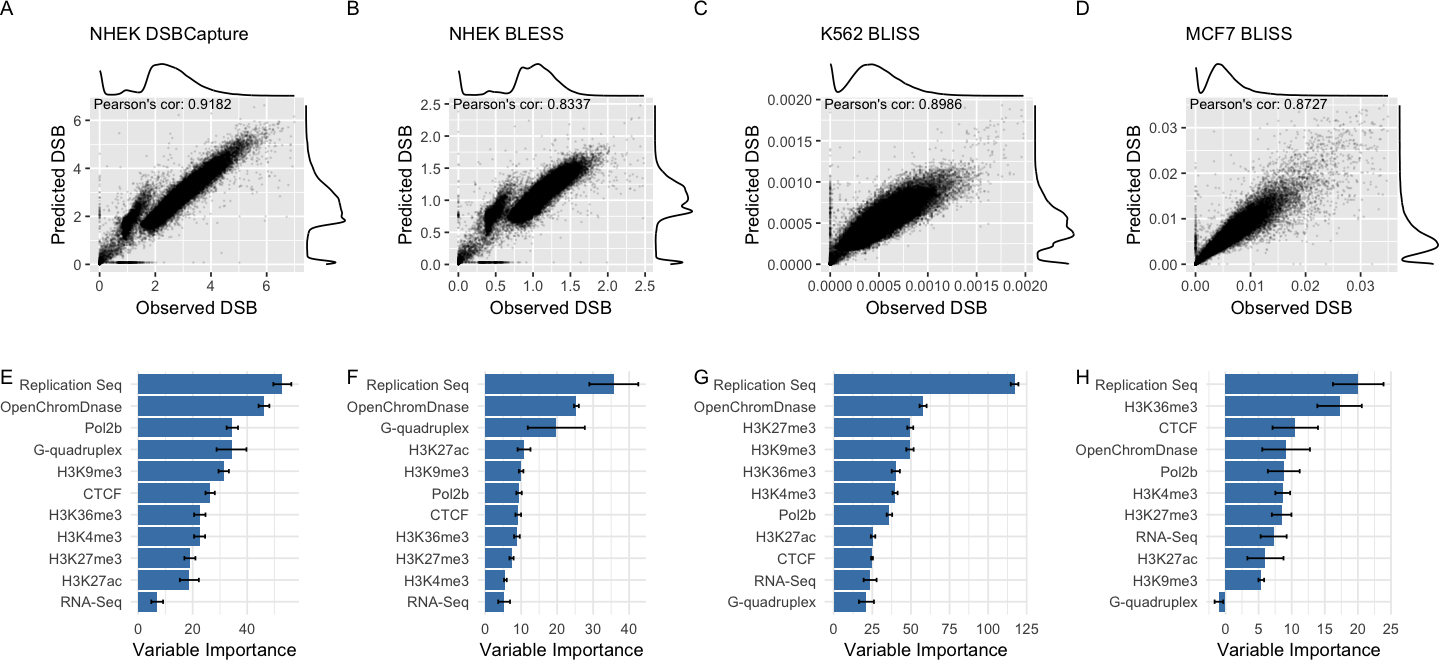

In [12]:
options(repr.plot.width=12, repr.plot.height=5.5)
g <- grid.arrange(grobs=mygrobs, ncol=4, heights=c(3.8,3), widths=c(1,1,1.1,1.05))

In [13]:
ggsave(file="Figure2.pdf", plot=g, path=paperfigdir, width=12, height=5.5, units="in", dpi=600)
ggsave(file="Figure2.png", plot=g, path=paperfigdir, width=12, height=5.5, units="in", dpi=600)

## Supp Fig 2: Heatmap of correlation between features

In [14]:
library('gplots')
feat=read.table("data/input_data/NHEK_features.tab", header=TRUE)
dat=feat[,5:ncol(feat)]
cmat <- cor(dat, use="pairwise.complete.obs", method="spearman")
row.names(cmat) <- fixlabels(row.names(cmat))

Warning message:
“package ‘gplots’ was built under R version 3.2.4”
Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



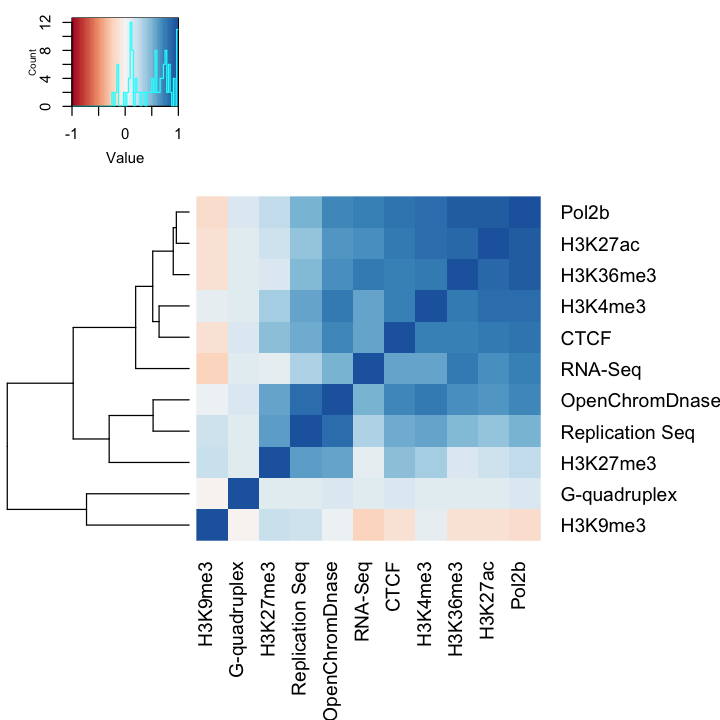

In [15]:
options(repr.plot.width=6, repr.plot.height=6)
#png(paste(supfigdir, "dendro.png", sep="/"), width=10, height=8)
heatmap.2(cmat, trace="none", dendrogram='row', 
          labCol=fixlabels(labels(cmat)[[2]]), margins=c(9,9), 
          col=colorRampPalette(brewer.pal(9, "RdBu"))(64), key.title=NA)

#dev.off()

# Figure4 - Cross application of models

## Data processing... 

In [13]:
compare_cross_models<- function(mymodel, myfeatures, mytrue){
    load(mymodel)
    nnames=labels(all.mod$importance)[[1]]
    nfix <- fixlabels(nnames)
    kfeat <- read.table(myfeatures, header=TRUE)
    kfeat <- kfeat[,5:ncol(kfeat)]
    knames=fixlabels(names(kfeat))
    newnames = nnames[pmatch(knames,nfix)]
    names(kfeat) <- newnames
    pnew <- predict(all.mod, newdata=kfeat)
    #pnew[is.na(pnew)]=0
    ktrue <- read.table(mytrue, header=TRUE)
    ktrue <- ktrue[,4]
    pnk1 <- cor.test(pnew, ktrue)
    return(pnk1)
}

In [14]:
modelN="data/randforest_results/NHEK_BREAK/all.mod.rdf"
modelK="data/randforest_results/K562_BLISS/all.mod.rdf"
modelM="data/randforest_results/MCF7_BLISS/all.mod.rdf"
featuresN="data/input_data/NHEK_features.tab"
featuresK="data/input_data/K562_features.tab"
featuresM="data/input_data/MCF7_features.tab"
trueN="data/input_data/NHEK_BREAK_50kb.bedgraph"
trueK="data/input_data/K562_BLISS_50kb.bedgraph"
trueM="data/input_data/MCF7_BLISS_50kb.bedgraph"

In [15]:
#####################################################
# Get correlations for predictions and actual values
# under various models. 
pn_n <- compare_cross_models(modelN, featuresN, trueN)

In [16]:
pn_k <- compare_cross_models(modelN, featuresK, trueK)

In [17]:
pn_m <- compare_cross_models(modelN, featuresM, trueM)

In [18]:
pk_k <- compare_cross_models(modelK, featuresK, trueK)
pk_n <- compare_cross_models(modelK, featuresN, trueN)
pk_m <- compare_cross_models(modelK, featuresM, trueM)

In [19]:
pm_m <- compare_cross_models(modelM, featuresM, trueM)
pm_n <- compare_cross_models(modelM, featuresN, trueN)
pm_k <- compare_cross_models(modelM, featuresK, trueK)

In [20]:
ktrue <- read.table(trueK, header=TRUE)[,4]
ntrue <- read.table(trueN, header=TRUE)[,4]
mtrue <- read.table(trueM, header=TRUE)[,4]
cnk <- cor(ntrue, ktrue)
cnm <- cor(ntrue, mtrue)
ckm <- cor(ktrue, mtrue)

## Plotting

In [21]:
### plot the correlation between the NHEK DSBCapture data and the predictions from various models. 
mycors=c()
for (p in list(pn_n, pn_k, pn_m, pk_n, pk_k, pk_m, pm_n, pm_k, pm_m)){
    mycors=c(mycors, p$estimate[[1]])
}
my_nomod <- c(1, cnk, cnm, cnk, 1, ckm, cnm, ckm, 1)
traindat <- factor(c("NHEK", "NHEK", "NHEK", "K562", "K562", "K562", "MCF7", "MCF7", "MCF7"),
                levels=c("NHEK", "K562", "MCF7"))
testingdat <- factor(c("NHEK", "K562", "MCF7", "NHEK", "K562", "MCF7", "NHEK", "K562", "MCF7"), 
                     levels=c("NHEK", "K562", "MCF7"))
df <- data.frame(y=mycors, x=testingdat, traindat=traindat, nomod=my_nomod)

myc1=brewer.pal(4, "Set2")[c(1,2,3)]
g <- ggplot(df, aes(x,y, fill=traindat)) + 
    geom_bar(stat="identity",  position=position_dodge(width=0.9)) +
    scale_fill_manual(values=myc1) + 
    labs(y="Pearson's Correlation", x="Input Cell Type", fill="Model Cell Type") + 
    theme(axis.text.x=element_text(colour=myc1, size=10))

In [22]:
# add the marks for where the correlation is between datasets 
g2 <- g + geom_text(aes(label="--", y=nomod, group=traindat), colour="navy", position=position_dodge(width=0.9))

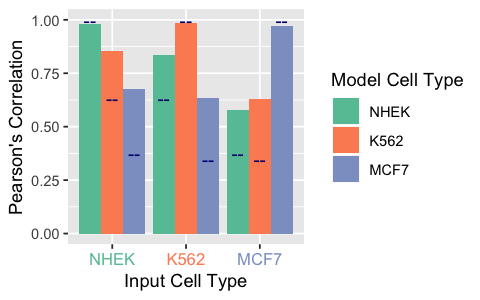

In [23]:
options(repr.plot.width=4, repr.plot.height=2.5)
g2
ggsave(file="Figure4.pdf", plot=g2, path=paperfigdir, width=4, height=2.5, units="in", dpi=600)
ggsave(file="Figure4.png", plot=g2, path=paperfigdir, width=4, height=2.5, units="in", dpi=600)

In [24]:
df

y,x,traindat,nomod
0.9781873,NHEK,NHEK,1.0000000
0.8336424,K562,NHEK,0.6348716
0.5790091,MCF7,NHEK,0.3791670
0.8527749,NHEK,K562,0.6348716
0.9836567,K562,K562,1.0000000
0.6299122,MCF7,K562,0.3508769
0.6764870,NHEK,MCF7,0.3791670
0.6322238,K562,MCF7,0.3508769
0.9720129,MCF7,MCF7,1.0000000


# Figure 3 - boxes and heatmaps
### Plotting functions 

In [25]:
################################################
# For Making a scatter plot of predicted versus 
# actual DSB frequencies. 
scatter_plot_predicted_p1<- function(mydir, myylim, myxlim, quantile=FALSE){
    predresults <- read.table(paste(mydir, "predicted.txt", sep="/"), header=TRUE)
    breaklabels <- predresults$breaks
    df <- data.frame(x=predresults$breaks, y = predresults$predicted)
    if (quantile){
        myylim=quantile(df$y, c(0.01, .99))
        myxlim=quantile(df$x, c(0.01, .99))
    }
    p=cor.test(df$x, df$y)
    if (p$p.value ==0){
        mytext=paste(" Pearson's cor: ", round(p$estimate, digits=4), sep="")  
                     #"\n p-value < 2.2e-16", sep="")
    }
    else {
    mytext=paste(" Pearson's cor: ", round(p$estimate, digits=4), sep="") 
       # "\n p-value: ", round(p$p.value, digits=4), sep="")
    }
    myi = df$x<=myxlim[2] & df$x >= myxlim[1] & df$y <= myylim[2] & df$y >= myylim[1]
    p1 <- ggplot(df[myi,], aes(x,y)) + geom_point(size=.1, alpha=0.1) + 
        xlab("Observed DSB\n\n") + ylab("\n\nPredicted DSB") +
        annotate("text", x=-Inf, y=Inf, label=mytext, vjust=1.1, hjust=0, size=3) + 
        theme(axis.text=element_text(size=9), text=element_text(size=11), plot.title=element_text(size=1))
    return(p1)
}

In [26]:
#### Making a heatmap of the features 
make_heat_map <- function(dat, mytitle="", featlabs=NULL, legend=TRUE, ylabs=TRUE){
    datm <- melt(dat, id.vars="id")
    datm$variable <- factor(datm$variable, levels=featlabs)
    mylabels=fixlabels(rev(featlabs))
    mylabels=sub("breaks", "Observed DSB", mylabels)
    mylabels=sub("predicted", "Predicted DSB", mylabels)
    mylabels=sub("mapability", "Mapability", mylabels)
    datm$value[datm$value>1]=1.1
    p1 <- ggplot(datm, aes(x=id, y=variable)) + 
        geom_tile(aes(fill=value)) + scale_fill_gradient(limits=c(0,1.1)) + 
        theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
        theme(plot.margin=unit(c(-1,0,1,0),"lines")) + 
        scale_y_discrete(limit=rev(featlabs), labels=mylabels) + 
        labs(x="", subtitle=mytitle, fill="value")
    if (legend == FALSE){ 
        p1 = p1 + guides(fill=FALSE) + theme(plot.margin=unit(c(-1, 0, 1, 0), "lines"))
    }
    if (ylabs){
        p1 = p1 + theme(axis.text.y=element_text(size=8), plot.margin=unit(c(-1,0,1,1), "lines")) + 
        labs(y="Features")
    }
    if (!ylabs){
        p1 = p1 + theme(axis.ticks.y=element_blank(), axis.text.y = element_blank(), 
                        plot.margin=unit(c(-1,0,1,-.5), "lines")) + 
        labs(y="")
    }
    return(p1)
}

## Figure 3: NHEK model

In [39]:
###  Read in the data and rescale it. 
mydir="data/randforest_results/NHEK_BREAK"
dat <- read.table("data/input_data/NHEK_features.tab", header=TRUE)
pdat <- read.table(paste(mydir, "predicted.txt", sep="/"), header=TRUE)
dat=dat[,4:ncol(dat)]
dat$predicted=pdat$predicted
dat$breaks=pdat$breaks
## add in mapability 
mapdat<- read.table("data/input_data/hg19_50kb_MapabilityAlign100mer.scores", header=TRUE)
dat$mapability<-mapdat$wgEncodeCrgMapabilityAlign100mer

dat$id <- with(dat, reorder(id, predicted))
for (i in seq(2, ncol(dat))){
    dat[,i]=rescale(dat[,i], to=c(0,1), from=quantile(dat[,i], c(.01, .99), na.rm=TRUE))
}
# Read in feature importance data and order by importance
impd <- read.table(paste(mydir, "var_imp.txt", sep="/"), header=FALSE)
if (ncol(impd)==2){
    m=impd[,2];
} else {
    m=apply(impd[,2:ncol(impd)], 1, mean, na.rm=TRUE)
}
datord <- order(m, decreasing=T)
myfeat=c("breaks", "predicted", as.character(impd$V1)[datord], "mapability")

In [40]:
## Get indices of sampled points for the range of predicted values. 
bins = seq(1.7,5, by=0.002)
xi=rep(0, (length(bins)-1))

for (i in c(1:(length(bins)-1))){
	xmin=bins[i]
	xmax=bins[i+1]
	indx=which(pdat$predicted >=xmin & pdat$predicted <xmax & pdat$breaks >= xmin-0.1 & pdat$breaks < xmax + 0.1)
	if (length(indx)==1){xi[i] = indx[1]}
    if (length(indx)>1){
		xi[i] = sample(indx, 1)
	}
}

xi=xi[xi!=0]
xisamp <- xi

## Set boundaries of boxes
limsA=c(.1, .6, .1, .9)
limsB=c(0.7, 1.5, 1.5, 2.7)
limsC=c(0.6, 1.8, 0, .2)


### Figure3a: scatter plot with highlighted regions

In [41]:
p <- scatter_plot_predicted_p1(mydir, myylim=c(0,6), myxlim=c(0,6))

lims=limsA
p <- p + annotate("rect", xmin=lims[1], xmax=lims[2], ymin=lims[3], ymax=lims[4], alpha=.2, colour="steelblue") + 
        annotate("text", x=lims[1], y=lims[4], label="A", colour="steelblue", hjust=-0.1, vjust=1.1, size=4)
lims=limsB
p <- p + annotate("rect", xmin=lims[1], xmax=lims[2], ymin=lims[3], ymax=lims[4], alpha=.2, colour="steelblue") + 
        annotate("text", x=lims[1], y=lims[4], label="B", colour="steelblue", hjust=-0.1, vjust=1.1, size=4)

subsamp <- pdat[xi,]
p <- p + geom_point(data=subsamp, aes(x=subsamp$breaks, y=subsamp$predicted), colour="steelblue", size=.2) + 
    annotate("text", x=2, y=4, label="C", colour="steelblue") + 
    annotate("segment", x=2, y=3.8, xend=2.5, yend=2.5, colour="steelblue")
pscat <- p

### Figure3 - all panels

In [42]:
mydat <- dat[xisamp,]
mytitle=paste("Group C: 1.7-5\n", "(", length(xisamp), ")", sep="")
prange <- make_heat_map(dat=mydat, featlabs=myfeat, mytitle=mytitle, ylabs=TRUE)

### Plots for Boxed regions
lims=limsA
xi <- pdat$breaks > lims[1] & pdat$breaks < lims[2] & pdat$predicted > lims[3] & pdat$predicted < lims[4]
mydat <- dat[xi,]
mytitle=paste("Box A: ", lims[1], "-", lims[2], "\n", "(", sum(xi), ")", sep="")
pboxA <- make_heat_map(dat=mydat, featlabs=myfeat, mytitle=mytitle, legend=FALSE, ylabs=TRUE)

lims=limsB
xi <- pdat$breaks > lims[1] & pdat$breaks < lims[2] & pdat$predicted > lims[3] & pdat$predicted < lims[4]
mydat <- dat[xi,]
mytitle=paste("Box B: ", lims[1], "-", lims[2], "\n", "(", sum(xi), ")", sep="")
pboxB <- make_heat_map(dat=mydat, featlabs=myfeat, mytitle=mytitle, legend=TRUE, ylabs=FALSE)

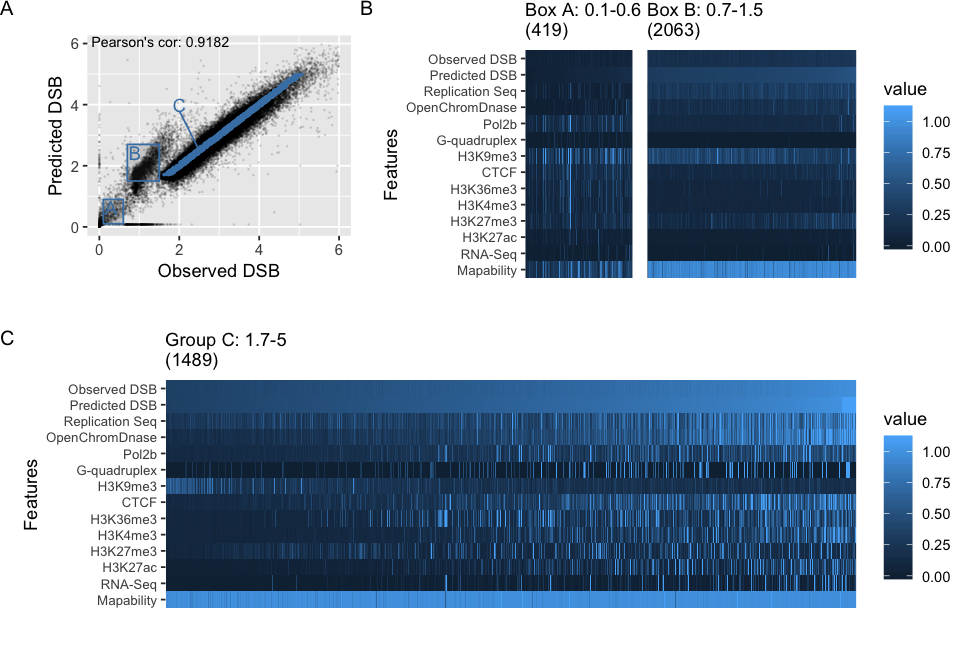

In [43]:
ps <- add_corner_label(pscat, "a")
gAB <- arrangeGrob(grobs=c(list(pboxA), list(pboxB)), ncol=2, widths=c(2.5,3))
gAB <- add_corner_label(gAB, "b")
gtop <- arrangeGrob(grobs=c(list(ps), list(gAB)), ncol=2, widths=c(3,5))
gbot <- arrangeGrob(grobs=c(list(prange)))
gbot <- add_corner_label(gbot, "c")
options(repr.plot.width=8, repr.plot.height=5.5)
g4 <- grid.arrange(gtop, gbot, nrow=2)

In [44]:
ggsave(file="Figure3.pdf", plot=g4, path=paperfigdir, width=8, height=5.5, units="in", dpi=600)
ggsave(file="Figure3.png", plot=g4, path=paperfigdir, width=8, height=5.5, units="in", dpi=600)

## Supp Figure 4 : extended NHEK model

In [45]:
###  Read in the data and rescale it. 
mydir="data/randforest_results/NHEK_BREAK_extended"
dat <- read.table("data/input_data/NHEK_extended_features.tab", header=TRUE)
pdat <- read.table(paste(mydir, "predicted.txt", sep="/"), header=TRUE)
dat=dat[,4:ncol(dat)]
dat$predicted=pdat$predicted
dat$breaks=pdat$breaks
## add in mapability 
mapdat<- read.table("data/input_data/hg19_50kb_MapabilityAlign100mer.scores", header=TRUE)
dat$mapability<-mapdat$wgEncodeCrgMapabilityAlign100mer

dat$id <- with(dat, reorder(id, predicted))
for (i in seq(2, ncol(dat))){
    dat[,i]=rescale(dat[,i], to=c(0,1), from=quantile(dat[,i], c(.01, .99), na.rm=TRUE))
}

# Read in feature importance data and order by importance
impd <- read.table(paste(mydir, "var_imp.txt", sep="/"), header=FALSE)
if (ncol(impd)==2){
    m=impd[,2];
} else {
    m=apply(impd[,2:ncol(impd)], 1, mean, na.rm=TRUE)
}
datord <- order(m, decreasing=T)
myfeat=c("breaks", "predicted", as.character(impd$V1)[datord], "mapability")

In [46]:
## Get indices of sampled points for the range of predicted values. 
bins = seq(1.7,5, by=0.002)
xi=rep(0, (length(bins)-1))

for (i in c(1:(length(bins)-1))){
	xmin=bins[i]
	xmax=bins[i+1]
	indx=which(pdat$predicted >=xmin & pdat$predicted <xmax & pdat$breaks >= xmin-0.1 & pdat$breaks < xmax + 0.1)
	if (length(indx)==1){xi[i] = indx[1]}
    if (length(indx)>1){
		xi[i] = sample(indx, 1)
	}
}

xi=xi[xi!=0]
xisamp <- xi

## Set boundaries of boxes
limsA=c(.1, .6, .1, .9)
limsB=c(0.6, 1.8, 0.5, .9)
limsC=c(0.7, 1.5, 1.5, 2.7)

In [47]:
p <- scatter_plot_predicted_p1(mydir, myylim=c(0,6), myxlim=c(0,6))

lims=limsA
p <- p + annotate("rect", xmin=lims[1], xmax=lims[2], ymin=lims[3], ymax=lims[4], alpha=.2, colour="steelblue") + 
        annotate("text", x=lims[1], y=lims[4], label="A", colour="steelblue", hjust=-0.1, vjust=1.1, size=4)
lims=limsB
p <- p + annotate("rect", xmin=lims[1], xmax=lims[2], ymin=lims[3], ymax=lims[4], alpha=.2, colour="steelblue") + 
        annotate("text", x=lims[2], y=lims[4], label="B", colour="steelblue", hjust=1.1, vjust=1.1, size=4)
lims=limsC
p <- p + annotate("rect", xmin=lims[1], xmax=lims[2], ymin=lims[3], ymax=lims[4], alpha=.2, colour="steelblue") + 
        annotate("text", x=lims[1], y=lims[4], label="C", colour="steelblue", hjust=-0.1, vjust=1.1, size=4)

subsamp <- pdat[xi,]
p <- p + geom_point(data=subsamp, aes(x=subsamp$breaks, y=subsamp$predicted), colour="steelblue", size=.2) + 
    annotate("text", x=2, y=4, label="D", colour="steelblue") + 
    annotate("segment", x=2, y=3.8, xend=2.5, yend=2.5, colour="steelblue")
pscat <- p

In [48]:
mydat <- dat[xisamp,]
mytitle=paste("Group D: 1.7-5\n", "(", length(xisamp), ")", sep="")
prange <- make_heat_map(dat=mydat, featlabs=myfeat, mytitle=mytitle, ylabs=FALSE)

### Plots for Boxed regions
lims=limsA
xi <- pdat$breaks > lims[1] & pdat$breaks < lims[2] & pdat$predicted > lims[3] & pdat$predicted < lims[4]
mydat <- dat[xi,]
mytitle=paste("Box A: ", lims[1], "-", lims[2], "\n", "(", sum(xi), ")", sep="")
pboxA <- make_heat_map(dat=mydat, featlabs=myfeat, mytitle=mytitle, legend=FALSE)

lims=limsB
xi <- pdat$breaks > lims[1] & pdat$breaks < lims[2] & pdat$predicted > lims[3] & pdat$predicted < lims[4]
mydat <- dat[xi,]
mytitle=paste("Box B: ", lims[1], "-", lims[2], "\n", "(", sum(xi), ")", sep="")
pboxB <- make_heat_map(dat=mydat, featlabs=myfeat, mytitle=mytitle, legend=TRUE, ylabs=FALSE)

lims=limsC
xi <- pdat$breaks > lims[1] & pdat$breaks < lims[2] & pdat$predicted > lims[3] & pdat$predicted < lims[4]
mydat <- dat[xi,]
mytitle=paste("Box C: ", lims[1], "-", lims[2], "\n", "(", sum(xi), ")", sep="")
pboxC <- make_heat_map(dat=mydat, featlabs=myfeat, mytitle=mytitle, legend=FALSE, ylabs=TRUE)


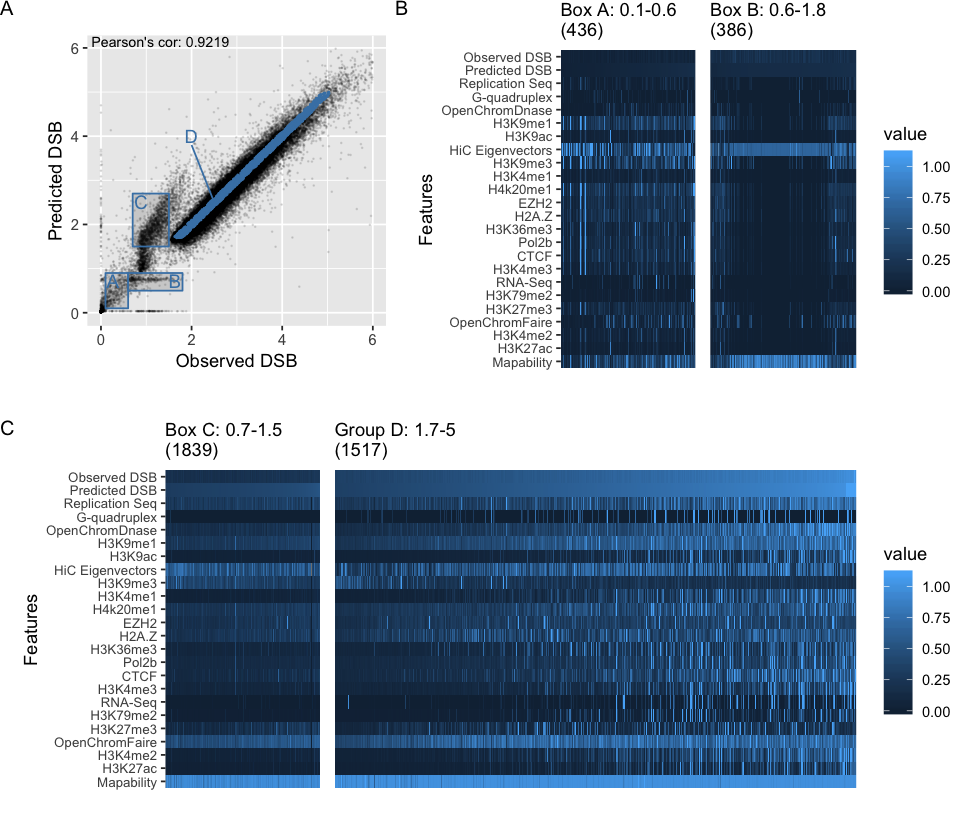

In [49]:
ps <- add_corner_label(pscat, "a")
gAB <- arrangeGrob(grobs=c(list(pboxA), list(pboxB)), ncol=2, widths=c(2.5,2.2))
gAB <- add_corner_label(gAB, "b")
gtop <- arrangeGrob(grobs=c(list(ps), list(gAB)), ncol=2, widths=c(3.5,5))
gCD <- arrangeGrob(grobs=c(list(pboxC), list(prange)), ncol=2, widths=c(3,6))
gCD <- add_corner_label(gCD, "c")
options(repr.plot.width=8, repr.plot.height=7)
g4 <- grid.arrange(gtop, gCD, nrow=2)

In [50]:
ggsave(file="SupFigure4_extended_NHEK_heatmap.pdf", plot=g4, path=supfigdir, width=8, height=7, units="in", dpi=600)
ggsave(file="SupFigure4_extended_NHEK_heatmap.png", plot=g4, path=supfigdir, width=8, height=7, units="in", dpi=600)